In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# A powerful and efficient gradient boosting model
import lightgbm as lgb

# Set some display options for better readability
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [5]:
# Load the datasets
try:
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    sample_submission_df = pd.read_csv("sample_submission.csv")
except FileNotFoundError:
    print("Ensure train.csv, test (1).csv, and sample_submission.csv are in the same directory.")
    # As a fallback for environments where files are not present, create empty dataframes
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()


print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)

print("\nFirst 5 rows of the training data:")
display(train_df.head())

print("\nFirst 5 rows of the testing data:")
display(test_df.head())

Training Data Shape: (18524, 9)
Testing Data Shape: (6175, 8)

First 5 rows of the training data:


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert



First 5 rows of the testing data:


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [6]:
print("Training Data Info:")
train_df.info()

print("\n" + "="*50 + "\n")

print("Missing values in training data:")
print(train_df.isnull().sum())

print("\n" + "="*50 + "\n")

print("Missing values in test data:")
print(test_df.isnull().sum())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


Missing values in training data:
id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside          

/tmp/ipykernel_4093/1261837022.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Personality', data=train_df, palette='viridis')


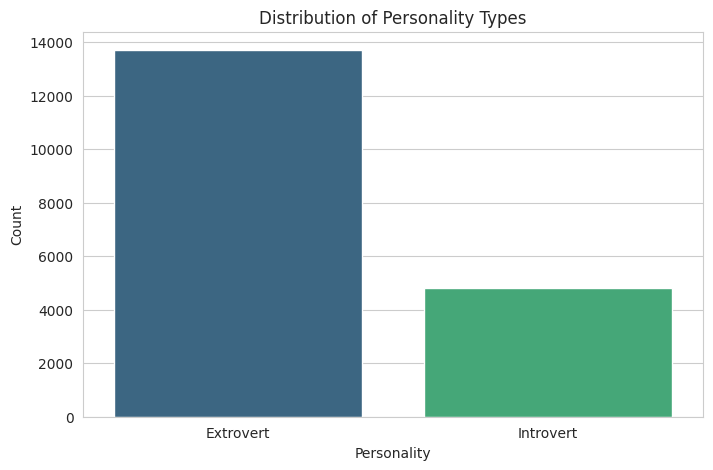

Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64


In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Personality', data=train_df, palette='viridis')
plt.title('Distribution of Personality Types')
plt.xlabel('Personality')
plt.ylabel('Count')
plt.show()

print(train_df['Personality'].value_counts(normalize=True))

Numerical Features: ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']


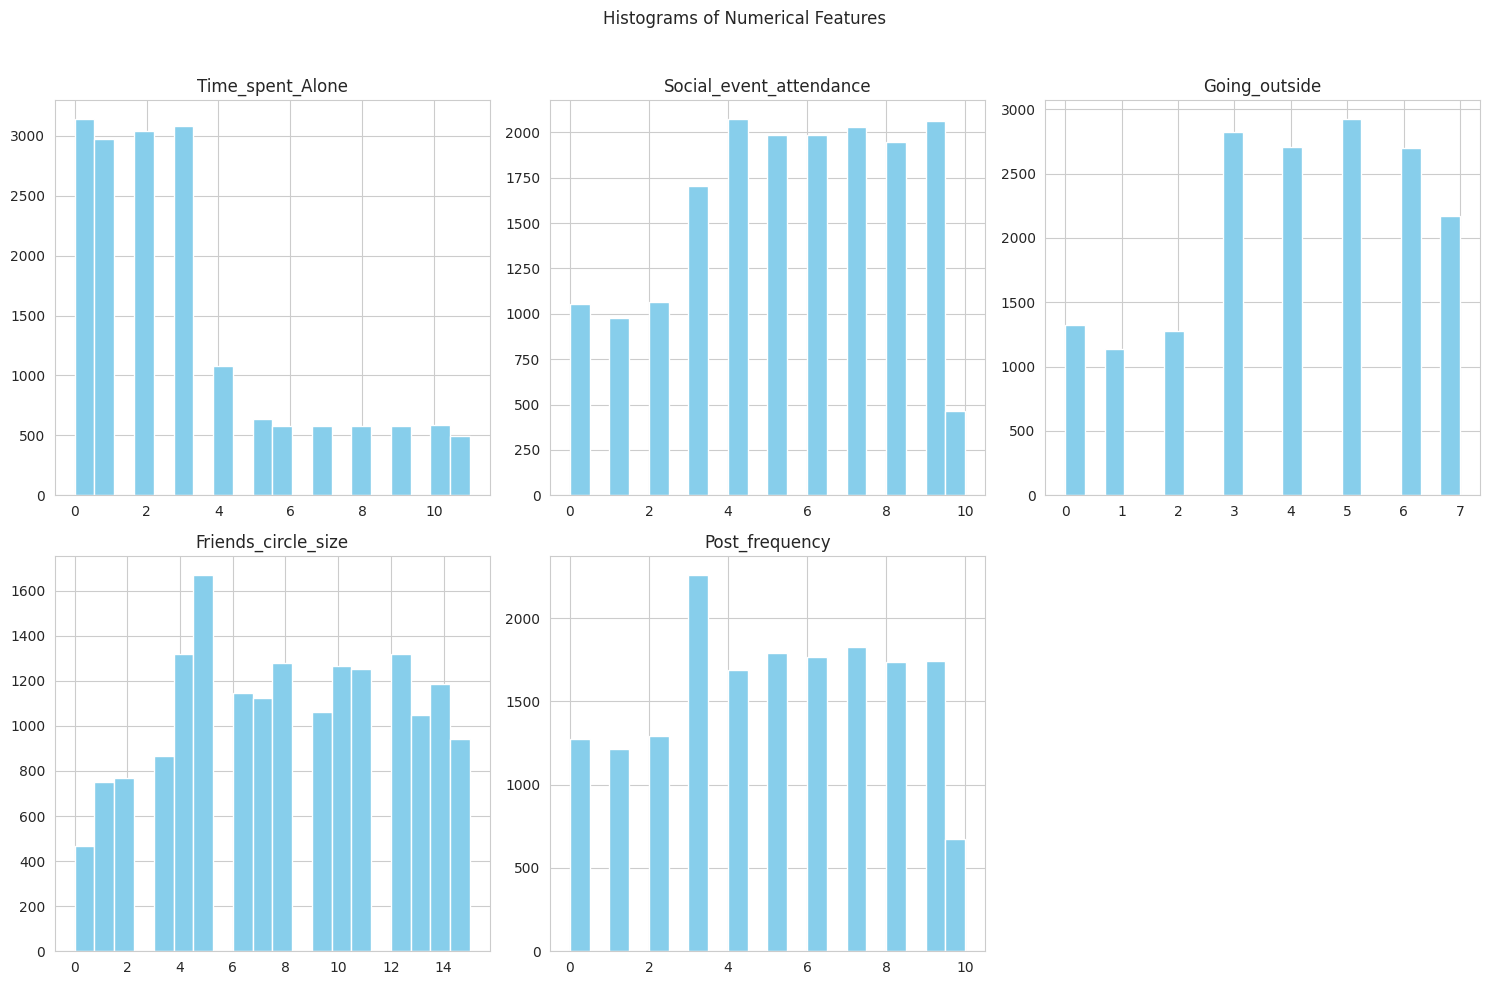

In [8]:
numerical_features = train_df.select_dtypes(include=np.number).columns.drop('id')
print("Numerical Features:", list(numerical_features))

# Plot histograms for numerical features
train_df[numerical_features].hist(bins=20, figsize=(15, 10), layout=(2, 3), color='skyblue')
plt.suptitle('Histograms of Numerical Features')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Categorical Features: ['Stage_fear', 'Drained_after_socializing']


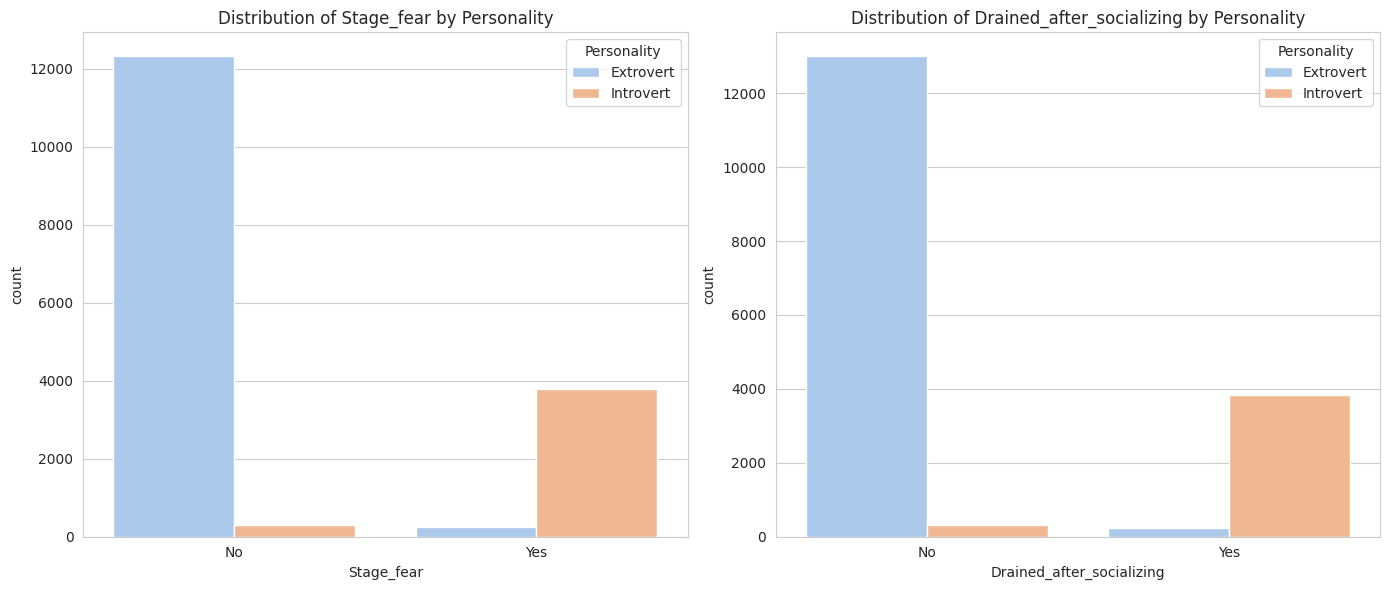

In [9]:
categorical_features = train_df.select_dtypes(include='object').columns.drop('Personality')
print("Categorical Features:", list(categorical_features))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, data=train_df, hue='Personality', ax=axes[i], palette='pastel')
    axes[i].set_title(f'Distribution of {col} by Personality')

plt.tight_layout()
plt.show()

In [10]:
# Separate target variable from features
X = train_df.drop('Personality', axis=1)
y = train_df['Personality']
X_test = test_df.copy() # Make a copy to avoid modifying the original test dataframe

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
# We can see the mapping: 0 -> Extrovert, 1 -> Introvert
print("LabelEncoder Classes:", le.classes_)

# Identify numerical and categorical feature names
numerical_cols = X.select_dtypes(include=np.number).columns.drop('id')
categorical_cols = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines for both numerical and categorical data
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Median is robust to outliers
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ],
    remainder='passthrough' # Keep other columns (like 'id') if any
)

LabelEncoder Classes: ['Extrovert' 'Introvert']
